In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import spacy
from spacy.lang.en import English
spacy.load('en_core_web_sm')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pickle
from helpers import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Train, validation and test dataset preparation. Data preprocessing.

In the previous workbook dataset has been reviewed, empty rows has been deleted. It's been identified that positive comments are doiminating in dataset.
In this workbook I will create three datasets: train, test and validation. 
**Due to performance issues** I have to leave only part of the dataset. In this case the final dataset before split will be 150000 of rows. The vocabulary size will be 100. This is tested and it has no MemoryError.
The steps that to go thru:
1. choose the part of the dataset to go forward;
2. split dataset for three different subsets of data.
3. data preprocessing:
    - data cleansing;
    - lemmazation;
    - creation of word2vec model;
    - creation of bag-of-words model in order to proceed with Naive Bayes;
4. train, validation and test datasets creation;


In [2]:
reviews = pd.read_csv('reviews.csv', sep=';')

In [3]:
reviews.shape

(6075266, 6)

In [4]:
reviews.head(5)

,review_id,text,stars,sentiment,length,bin
0,x7mDIiDB3jEiPGPHOmDzyw,The pizza was okay. Not the best I've had. I p...,2.0,0.0,450,0
1,dDl8zu1vWPdKGihJrwQbpw,I love this place! My fiance And I go here atl...,5.0,2.0,317,0
2,LZp4UX5zK3e-c5ZGSeo3kA,Terrible. Dry corn bread. Rib tips were all fa...,1.0,0.0,156,0
3,Er4NBWCmCD4nM8_p1GRdow,Back in 2005-2007 this place was my FAVORITE t...,2.0,0.0,901,1
4,jsDu6QEJHbwP2Blom1PLCA,Delicious healthy food. The steak is amazing. ...,5.0,2.0,165,0


In [5]:
reviews = reviews.loc[:, ('review_id', 'text', 'sentiment')]

In [6]:
pos = reviews[reviews['sentiment'] == 2.0]
neg = reviews[reviews['sentiment'] == 0.0]
neu = reviews[reviews['sentiment'] == 1.0]
print(f'''
Number of positive:\t{len(pos)}
Number of negative:\t{len(neg)}
Number of neutral:\t{len(neu)}
''')


Number of positive:	3977837
Number of negative:	1358663
Number of neutral:	673206



Taking 50001 records of each type. Before shuffling them in random order. Also counting number of tokens - approximately. The limit will be 100. So the biggest array before training neural network will be (90000, 100, 100).

In [7]:
nrTokens = [len(str(x).split(' ')) for x in reviews['text']]
reviews['nrTokens'] = nrTokens
print(max(nrTokens), min(nrTokens), np.mean(nrTokens))

4329 1 111.02604560853797


In [8]:
print(len(reviews[reviews['nrTokens'] <= 100]))
reviews = reviews[reviews['nrTokens'] <= 100].reset_index(drop=True)
pos = reviews[reviews['sentiment'] == 2.0]
neg = reviews[reviews['sentiment'] == 0.0]
neu = reviews[reviews['sentiment'] == 1.0]
print(f'''
Number of positive:\t{len(pos)}
Number of negative:\t{len(neg)}
Number of neutral:\t{len(neu)}
''')

3695171

Number of positive:	2646596
Number of negative:	649978
Number of neutral:	333037



In [9]:
def randomizing_sampling(df, n=50000):
    df = df.sample(frac=1)
    df = df.reset_index(drop=True)
    df = df.loc[:n, :]
    return df

In [10]:
pos = randomizing_sampling(pos)

In [11]:
print(len(pos))

50001


In [12]:
pos.head(5)

,review_id,text,sentiment,nrTokens
0,uuSinjYmrz4f1waM0I4rvg,Awesome food.Great Service. This place you pay...,2.0,15
1,_zAGAaRt1jfTEZtEDTMxkg,This place is great. I have bought multiple pi...,2.0,26
2,sq5jjIo6giWlDKjuKqiCiA,Delicious sushi and awesome lunch special! The...,2.0,42
3,CYCN8nwsFy1IpKSBOaNW0w,We took our Siberian Husky today at Pretty Paw...,2.0,49
4,bOx21rDXDk9bMITku7oS1w,"Got the original gryo, and must say it was qui...",2.0,54


In [13]:
neu = randomizing_sampling(neu)
print(neu.shape)
print('------------------------')
print(neu.loc[:5, :])

(50001, 4)
------------------------
                review_id                                               text  \
0  x1fd7I6ns2ePKZo6eu_7Aw  Decent place to grab a slice of pizza. Prices ...   
1  jcCbtIB6iVp_UNcLoz8Xqg  I am in Matthews all the time but have been to...   
2  Ergr6511E8c8k_v1yQbuAw  Poetry was off the chain...no doubt. Michelle ...   
3  0CFD-wG7s5YHL35tM7H_4A  This course is wide open without a ton of wate...   
4  qArUIG2q36oN56y7sG9nHQ  I arrived at 7:30 with reservations and I'm ju...   
5  zTsajpKzXQ7RykCVWOaA7Q  I came here to play over the Summer of 2015 an...   

   sentiment  nrTokens  
0        1.0        24  
1        1.0        90  
2        1.0        72  
3        1.0        64  
4        1.0        51  
5        1.0        93  


In [14]:
neg = randomizing_sampling(neg)
print(neg.shape)
print('------------------------')
print(neg.loc[:5, :])

(50001, 4)
------------------------
                review_id                                               text  \
0  Vby_gTR0o9SA8dhVktXjWQ  This is the slowest pharmacy ever! I don't thi...   
1  p9MPuQzu9JLrg2YcHhV8Ug  Been going to Mr. Lucky's for years.  Had the ...   
2  EyNOa8LkDeJ-TpmBtWqeTQ  Extremely digusted that there is very strong b...   
3  AIv9A0sQttHXVb2VfsfPWQ  This store has improved since I was last there...   
4  7XoUrySynjvY0yudKcuRmg  Pizza was not as authentic Chicago pizza as I ...   
5  FsnkgVERaDnxAjjpkWDneA  Used to be a FIVE STAR place. These days, we c...   

   sentiment  nrTokens  
0        0.0        82  
1        0.0        32  
2        0.0        46  
3        0.0        28  
4        0.0        54  
5        0.0        94  


Before splitting to train, test and validation, combining subsets.

In [15]:
dataset = pd.concat([pos, neg, neu], axis=0).sample(frac=1).reset_index(drop=True)
print(dataset.head(5))

                review_id                                               text  \
0  2jI-wWlPIPp43Oh6He7lAA  This place obviously is banking on its famous ...   
1  yhfYMsOKgU9_yTgnc6hPLw  Got an original black milk tea with 70% sugar,...   
2  aLW1laX76NxZs3tG1Yd5iA  I have been here before and I was not impresse...   
3  mDFeaQjocT5cKctp60fIiQ  Men's fragrance. Sales girl wouldn't let me br...   
4  vzZ7YO4cX_Bl8LmvkJPyEg  Located in Excalibur on the 2nd floor, this pl...   

   sentiment  nrTokens  
0        1.0        80  
1        1.0        85  
2        0.0        82  
3        1.0        76  
4        0.0        35  


In [16]:
#saving dataset in case its needed
dataset = dataset.loc[:, ('review_id', 'text', 'sentiment')]
dataset.to_csv('pre_split_dataset_v2.csv', sep=';')

In [17]:
ids = dataset['review_id']
X = dataset['text']
y = dataset['sentiment']
del reviews, neg, neu, pos, dataset, nrTokens
print(X[0], y[0])

This place obviously is banking on its famous founder. It's ok. 5 Guys is better. I thought the service was slow and they could really care less about providing a good dining experience. The tables were dirty as well and we had to wait for them to call me and clean them. The bartender was nice and pretty quick. We would've skipped it but my 11 year old wanted to eat there. The shakes looked pretty small for the price. 1.0


In [18]:
y.to_csv('y_v2.csv', sep=';')
ids.to_csv('ids_v2.csv', sep=';')
X.to_csv('X_v2.csv', sep=';')

In order not to run text preprocessing several times, it will be done for the the whole dataset.

In [19]:
print(len(X), len(y))

150003 150003


In [20]:
#splitting words to tokens, lemmatization, removing stop words
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    tkns = []
    text = re.sub('[^a-zA-Z]', ' ', text)
    doc = nlp(text)
    for token in doc:
        if token.is_digit:
            pass
        elif token.is_space:
            pass
        elif token.is_punct:
            pass
        elif token.is_stop:
            pass
        elif len(token) <= 3:
            pass
        else:
            tkns.append(token.lemma_.lower())
    return tkns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
X_processed = []
for i, sent in enumerate(X.values):
    if i % 1000 == 0:
        print(f'Processing sentence: {i}')
    tkns = tokenize(sent)
    X_processed.append(tkns)

Processing sentence: 0
Processing sentence: 1000
Processing sentence: 2000
Processing sentence: 3000
Processing sentence: 4000
Processing sentence: 5000
Processing sentence: 6000
Processing sentence: 7000
Processing sentence: 8000
Processing sentence: 9000
Processing sentence: 10000
Processing sentence: 11000
Processing sentence: 12000
Processing sentence: 13000
Processing sentence: 14000
Processing sentence: 15000
Processing sentence: 16000
Processing sentence: 17000
Processing sentence: 18000
Processing sentence: 19000
Processing sentence: 20000
Processing sentence: 21000
Processing sentence: 22000
Processing sentence: 23000
Processing sentence: 24000
Processing sentence: 25000
Processing sentence: 26000
Processing sentence: 27000
Processing sentence: 28000
Processing sentence: 29000
Processing sentence: 30000
Processing sentence: 31000
Processing sentence: 32000
Processing sentence: 33000
Processing sentence: 34000
Processing sentence: 35000
Processing sentence: 36000
Processing sen

Before proceeding further, saving tokens. In general tokenazation took 10 hours with 1,5 mlns of data.
**Due to performance issues** dataset has been cutted. With 150k samples it took around 1 hour to be tokenized.

In [22]:
#save tokens
with open("tokens_v2.txt", "wb") as f:
    pickle.dump(X_processed, f)

Checking the length of the list:

In [23]:
len(X_processed)

150003

Comparing tokenized and original text

In [24]:
print(X_processed[150002])
print('----------------------------------')
print(X[150002])

['food', 'fantastic', 'service', 'spectacular', 'calamari', 'soooooo', 'good', 'tre', 'lech', 'devine', 'coconut', 'cake', 'world']
----------------------------------
The food is fantastic and the service is spectacular! The calamari is soooooo good and the tres leches is Devine. The coconut cake is out of this world


#### Building word2vec model

Building word2vec model. To speed up the performance all the available cpu will be used. Gensim library has a **workers** parameter which could do a parallelization

In [25]:
from gensim.models.word2vec import Word2Vec
import multiprocessing

C:\Users\miska\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [26]:
multiprocessing.cpu_count()

8

In [27]:
vector_size = 100
window_size = 10
model_100 = Word2Vec(sentences=X_processed,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=multiprocessing.cpu_count())

In [28]:
vector_size = 120
window_size = 10
model_120 = Word2Vec(sentences=X_processed,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=multiprocessing.cpu_count())

Saving models

In [29]:
model_100.save('word2vec_model_100.model')
model_120.save('word2vec_model_120.model')

Checking similarity for some of the words:

In [30]:
#to turn of future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
print(model_100.wv.most_similar('pizza'))
print('------------------------------------------------')
print(model_120.wv.most_similar('good'))
print('------------------------------------------------')
print(model_100.wv.most_similar('friend'))


[('pepperoni', 0.8266472220420837), ('crust', 0.7232790589332581), ('sicilian', 0.6870665550231934), ('calzone', 0.683086097240448), ('stromboli', 0.6582770943641663), ('domino', 0.6569181680679321), ('dominos', 0.653199315071106), ('margherita', 0.6494368314743042), ('pizzas', 0.6378195285797119), ('breadstick', 0.6357826590538025)]
------------------------------------------------
[('decent', 0.7954224348068237), ('okay', 0.715410053730011), ('average', 0.6679041981697083), ('alright', 0.6622477769851685), ('great', 0.6617214679718018), ('solid', 0.647891104221344), ('tasty', 0.5928990840911865), ('mediocre', 0.5580964088439941), ('pretty', 0.5186408758163452), ('excellent', 0.5143110752105713)]
------------------------------------------------
[('boyfriend', 0.6207457184791565), ('buddy', 0.6178157329559326), ('girlfriend', 0.6062629818916321), ('brother', 0.5595120191574097), ('coworker', 0.5583606362342834), ('sister', 0.5525801181793213), ('wife', 0.5474111437797546), ('fianc', 0.5

#### Building train, validation and test dataset.

In [32]:
max_length = 0
avg_length = 0.
for rev in X_processed:
    if len(rev) > max_length:
        max_length = len(rev)
    avg_length += float(len(rev))
    
print(f'Average length: {(avg_length / float(len(X_processed)))}')
print(f'Max length: {max_length}')

Average length: 22.85528956087545
Max length: 81


Checking the length of vocabulary:

In [33]:
print(len(model_100.wv.vocab))
print(len(model_120.wv.vocab))

15750
15750


In [34]:
#printing vector for one of the word:
print(model_120.wv['yelp'])
print('---------------------------')
print(model_100.wv['yelp'])

[ 4.6699367e+00  3.8705268e+00  1.6811979e+00  7.0431769e-01
 -2.8051505e+00 -2.9737971e+00  3.3105412e+00 -8.2364136e-01
  4.1397358e-03 -1.1040767e+00 -4.6735897e+00 -1.9934195e+00
  2.9933398e+00 -4.0273732e-01  5.3374934e+00 -3.0846293e+00
 -2.1608045e+00 -1.7793059e+00  3.5693860e+00 -6.4813423e-01
  8.2146108e-01  2.9945493e+00 -1.5270591e+00  2.5315292e+00
  1.8289448e+00  1.8892965e+00 -1.7710371e+00 -1.4202898e+00
 -2.5230930e+00 -2.4085748e+00  4.7998229e-01  4.5988092e+00
 -4.4786110e+00  5.4492664e-01 -4.1238803e-01  8.9703250e-01
 -9.3728721e-01  2.6379950e+00  1.4805388e-01 -2.8180408e+00
  2.9242811e+00 -2.8265269e+00  2.6157434e+00  2.7260962e+00
 -3.1530564e+00 -7.0331305e-01 -3.8534279e+00 -2.5694835e-01
 -7.1413279e-01 -2.9574597e+00 -7.7574706e-01 -2.2245313e-01
  4.1568220e-01 -8.8880189e-02  2.8198404e+00  1.1841465e-01
 -3.0778041e+00 -5.1760402e+00  1.8811582e+00  1.9349972e+00
 -1.3718400e+00 -1.1937397e+00  3.7494915e+00 -2.5681317e-01
  2.2082421e-01  2.32365

In [35]:
ind = np.arange(0, len(X_processed))

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ind, y, test_size=0.4, random_state=0, shuffle=True, stratify=y)

In [37]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

90001 90001
60002 60002


In [38]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0, shuffle=True)
print(len(X_test), len(y_test))
print(len(X_val), len(y_val))

30001 30001
30001 30001


Final dataset will be called: Xtrain, Xval and Xtest/ labels ytrain, yval, ytest
To build X datasets we should create a multidimensional arrays as following:
 - Xtrain: (train_size, max_length, vector_size);
 - Xval: (val_size, max_length, vector_size);
 - Xtest: (test_size, max_length, vector_size)

Labels should be converted to one_hot representation:
 - if 2.0 then [0. 0. 1]
 - if 1.0 then [0. 1. 0]
 - if 0.0 then [1. 0. 0]

Trying model with vector size 120.

In [39]:
#initializing datasets:
import cupy as cp
import numpy as np

Xtrain = np.zeros(shape=(X_train.shape[0], max_length, vector_size))
Xval = np.zeros(shape=(X_val.shape[0], max_length, vector_size))
Xtest = np.zeros(shape=(X_test.shape[0], max_length, vector_size))
ytrain = np.zeros(shape=(len(y_train), 3))
yval = np.zeros(shape=(len(y_val), 3))
ytest = np.zeros(shape=(len(y_test), 3))

Checking if everything has been built correctly:

In [40]:
ytrain[0]

array([0., 0., 0.])

In [41]:
X_processed[X_train[0]]

['sorry',
 'news',
 'clear',
 'shop',
 'today',
 '-pron-',
 'half',
 'year',
 'look',
 'like',
 'go',
 '-pron-',
 'miss',
 'neighborhood']

In [42]:
model_120.wv['review']

array([-3.7696753 ,  3.687721  ,  1.6801515 ,  0.8196675 ,  2.0146296 ,
       -4.1688905 , -3.1715105 , -6.978157  ,  0.7193216 ,  0.3481072 ,
       -7.356078  , -0.89824426, -0.5851278 , -0.75918955, -1.5559213 ,
       -5.4218016 , -1.5162423 , -1.2136823 ,  3.0315645 , -1.6334547 ,
       -2.8124897 ,  3.607327  ,  2.5872128 ,  3.958662  ,  1.5244466 ,
        1.3282211 ,  4.275572  , -2.4526243 , -3.627014  ,  0.01084524,
       -1.9644157 ,  4.226262  , -4.4557433 ,  3.7251415 , -2.6791158 ,
       -0.22584993,  0.52675706, -3.6440122 , -0.22437477, -2.4312036 ,
        2.5791447 , -0.7308614 ,  0.65970397, -1.2018596 ,  2.3510695 ,
        0.62774837, -5.96115   ,  0.45067772, -1.4519044 ,  1.4176434 ,
       -3.8273563 ,  9.533207  ,  6.715327  , -2.6036987 ,  0.5901922 ,
       -1.7479063 ,  0.9584274 , -1.2417247 , -0.40537253,  1.5448538 ,
        2.366233  , -4.1581526 ,  0.9389244 ,  2.2161133 ,  2.9547975 ,
        0.44846684,  2.4244688 , -1.1432824 ,  2.6030345 ,  1.88

In [43]:
for index_ in X_train[:5]:
    print(index_)
    print(X_processed[index_])
    print('-------------------------')

68499
['sorry', 'news', 'clear', 'shop', 'today', '-pron-', 'half', 'year', 'look', 'like', 'go', '-pron-', 'miss', 'neighborhood']
-------------------------
22845
['brisket', 'sandwich', 'good', 'sauce', 'ranch', 'taste', 'good', 'sweet', 'potatoe', 'fry', 'kinda', 'soggy', 'crispy', 'garden', 'salad', 'cheese', 'good', 'accord', 'picky', 'friend', 'say']
-------------------------
104459
['loud', 'necessary', 'truthful', 'review', 'coleslaw', 'cheese', 'baby', 'backs', 'louis', 'ribs', 'famous', 'dave', 'wasn', 'miss', 'just', 'high', 'expectation', 'ribs', 'snappy', 'tender', 'service', 'extremely', 'rush', 'hurry', 'leave', 'turn', 'table', 'money', 'know', 'try', 'disappoint']
-------------------------
36971
['like', 'bourbon', 'sour', 'highlight', 'prosciutto', 'pizza', 'good', 'tasting', 'atmosphere', 'italian', 'restaurant', 'classy', 'upscale']
-------------------------
63694
['delicious', 'food', 'positive', 'review', 'yelp', 'decide', 'wasn', 'disappoint', 'owner', 'friendly'

In [3]:
def building_subset(X_train, Xtrain, X_processed, word2vec, ytrain, y_train):
    for train_ind, index_ in enumerate(X_train):
        tokens = X_processed[index_]
        for token_id, token in enumerate(tokens):
            if token not in word2vec.wv:
                pass
            else:
                Xtrain[train_ind, token_id, :] = word2vec.wv[str(token)]
        if y_train[index_] == 0.0:
            ytrain[train_ind, :] = [1., 0., 0.]
        elif y_train[index_] == 1.0:
            ytrain[train_ind, :] = [0., 1., 0.]
        else:
            ytrain[train_ind, :] = [0., 0., 1.]
    return Xtrain, ytrain

In [45]:
Xtrain, ytrain = building_subset(X_train, Xtrain, X_processed, model_120, ytrain, y_train)

Checking on "review" word from the second sentence in X_train dataset

In [46]:
Xtrain[0, 1, :]

array([ 2.1747973 ,  1.56801069,  0.88525897,  0.45513266,  0.12252418,
       -2.01937437, -0.89725822, -1.08528936,  0.57925564,  0.37952843,
       -1.84325528, -0.56999099,  0.36088121, -4.15854216,  0.24179475,
       -1.41240954,  1.30264449, -2.46974993, -3.0126946 , -2.1506865 ,
        2.87368464, -0.69415182,  3.05139804,  0.60078794,  1.53934443,
        0.76762193, -2.12567043, -1.08836627, -2.0799911 , -1.92362833,
       -0.08724946, -1.31737852, -2.0426333 , -3.32874775, -1.51043224,
       -1.67988646, -2.99336243,  2.52708721,  0.01396178, -0.13106452,
        1.93881524,  2.77460742,  4.53741121,  1.17581916, -1.46387196,
       -0.05875344,  0.65480202,  1.52654827,  2.52466846, -0.79763734,
       -3.76870227,  1.04703629,  3.1318984 , -3.30613756, -0.06503484,
        0.32446393,  0.98976654, -0.81557137, -2.03937674,  1.01909387,
       -1.09753048,  1.86334109,  1.3356967 , -2.89209223, -1.42287958,
        2.58327055,  2.0182128 , -1.48660779,  0.05174031,  3.77

In [47]:
ytrain[0]

array([1., 0., 0.])

In [48]:
Xtest, ytest = building_subset(X_test, Xtest, X_processed, model_120, ytest, y_test)
Xval, yval = building_subset(X_val, Xval, X_processed, model_120, yval, y_val)

Subsets for neural network are ready.

#### Building corpus for bag of word model:

In [49]:
corpus = []
for l in X_processed:
    corpus.append(' '.join(str(x) for x in l))

Creating bag-of-words model:

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
nB_x = cv.fit_transform(corpus[:10000]).toarray()
nB_y = y.loc[:9999].values

Using standard algorithms to take some baseline:

#### Naive Bayes

In [115]:
from sklearn.cross_validation import train_test_split
nBx_train, nBx_test, nBy_train, nBy_test = train_test_split(nB_x, nB_y, test_size = 0.20, random_state = 0)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
gNB = GaussianNB()
gNB.fit(nBx_train, nBy_train)

# Predicting the Test set results
gnBy_pred = gNB.predict(nBx_test)

#### Multinomial Naive Bayes

In [126]:
from sklearn.naive_bayes import MultinomialNB
mNB = MultinomialNB(alpha=0.5)
mNB.fit(nBx_train, nBy_train)

# Predicting the Test set results
mnBy_pred = mNB.predict(nBx_test)

In [127]:
from sklearn.metrics import accuracy_score
print(f'''
Gausian NaiveBayes:\t{accuracy_score(nBy_test, gnBy_pred)}
Multinomial NaiveBayes:\t{accuracy_score(nBy_test, mnBy_pred)}
''')


Gausian NaiveBayes:	0.442
Multinomial NaiveBayes:	0.6545



#### Logistic Regression

In [129]:
from sklearn.linear_model import LogisticRegression
lR = LogisticRegression(random_state=0)
lR.fit(nBx_train, nBy_train)

lRy_pred = lR.predict(nBx_test)
print(f'Logistic Regression accuracy: {accuracy_score(nBy_test, lRy_pred)}')

Logistic Regression accuracy: 0.6735


In [132]:
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty': ('l1', 'l2'), 'C': [0.1, 1, 10]}
gSrch = GridSearchCV(lR, param_grid=param_grid, scoring='accuracy')

In [135]:
gSrch.estimator

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier
rF = RandomForestClassifier(n_estimators=500, criterion='entropy')
rF.fit(nBx_train, nBy_train)

rFy_pred = rF.predict(nBx_test)
print(f'Random Forest accuracy: {accuracy_score(nBy_test, rFy_pred)}')

C:\Users\miska\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Random Forest accuracy: 0.6745


#### Ensemble: Voting Classifier.

In [140]:
nBy_train[:10]

array([2., 2., 2., 0., 0., 0., 0., 0., 1., 0.])

In [141]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('logistic', lR), ('randomforest', rF)], voting='soft')
eclf.fit(nBx_train, nBy_train)
ens_y_pred = eclf.predict(nBx_test)
print(f'Ensemble accuracy: {accuracy_score(nBy_test, ens_y_pred)}')

C:\Users\miska\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Ensemble: 0.678


#### Convolutional neural network Keras

Importing keras

In [50]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [52]:
#initial model
# inspired by https://arxiv.org/pdf/1710.05978.pdf
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 81, 32)            11552     
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 81, 32)            2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

In [54]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

In [55]:
# Fit the model
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 40s - loss: 0.8744 - acc: 0.6266 - val_loss: 0.6430 - val_acc: 0.7240
Epoch 2/100
 - 29s - loss: 0.6818 - acc: 0.7032 - val_loss: 0.6158 - val_acc: 0.7342
Epoch 3/100
 - 28s - loss: 0.6343 - acc: 0.7251 - val_loss: 0.5954 - val_acc: 0.7421
Epoch 4/100
 - 28s - loss: 0.6099 - acc: 0.7348 - val_loss: 0.5881 - val_acc: 0.7441
Epoch 5/100
 - 28s - loss: 0.5974 - acc: 0.7410 - val_loss: 0.5829 - val_acc: 0.7461
Epoch 6/100
 - 28s - loss: 0.5892 - acc: 0.7455 - val_loss: 0.5777 - val_acc: 0.7479
Epoch 7/100
 - 28s - loss: 0.5825 - acc: 0.7479 - val_loss: 0.5763 - val_acc: 0.7488
Epoch 8/100
 - 28s - loss: 0.5772 - acc: 0.7513 - val_loss: 0.5738 - val_acc: 0.7505
Epoch 9/100
 - 28s - loss: 0.5730 - acc: 0.7527 - val_loss: 0.5736 - val_acc: 0.7506
Epoch 10/100
 - 28s - loss: 0.5698 - acc: 0.7539 - val_loss: 0.5714 - val_acc: 0.7504
Epoch 11/100
 - 31s - loss: 0.5670 - acc: 0.7558 - val_loss: 0.5702 - val_acc: 0.7514
Epoch 12/100


Accuracy for Neural Network:

In [56]:
from sklearn.metrics import accuracy_score
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
accuracy_score(y_test[X_test].values, ypred_nn)

0.7562081263957868

To visualize the curves building a function:

In [14]:
def visualize_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valditaion'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

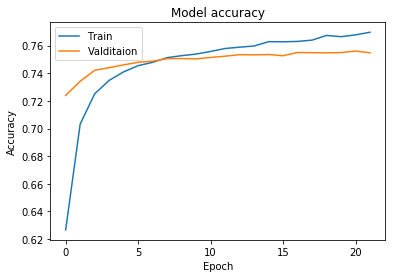

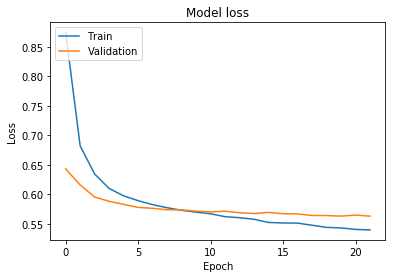

In [59]:
visualize_history(history)

#### Tweaking parameters and changing the architecture:

In [60]:
#changing learning rate
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.25))

model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, decay=1e-6),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 37s - loss: 0.6820 - acc: 0.7081 - val_loss: 0.6062 - val_acc: 0.7389
Epoch 2/100
 - 29s - loss: 0.6170 - acc: 0.7340 - val_loss: 0.5869 - val_acc: 0.7445
Epoch 3/100
 - 29s - loss: 0.6069 - acc: 0.7377 - val_loss: 0.5806 - val_acc: 0.7464
Epoch 4/100
 - 29s - loss: 0.5994 - acc: 0.7408 - val_loss: 0.5867 - val_acc: 0.7486
Epoch 5/100
 - 29s - loss: 0.5954 - acc: 0.7428 - val_loss: 0.5802 - val_acc: 0.7472
Epoch 6/100
 - 29s - loss: 0.5938 - acc: 0.7453 - val_loss: 0.5775 - val_acc: 0.7507
Epoch 7/100
 - 29s - loss: 0.5891 - acc: 0.7456 - val_loss: 0.5707 - val_acc: 0.7535
Epoch 8/100
 - 28s - loss: 0.5903 - acc: 0.7463 - val_loss: 0.5708 - val_acc: 0.7551
Epoch 9/100
 - 28s - loss: 0.5871 - acc: 0.7477 - val_loss: 0.5755 - val_acc: 0.7553


In [61]:
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
accuracy_score(y_test[X_test].values, ypred_nn)

0.7501416619446019

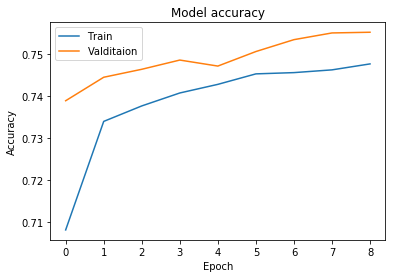

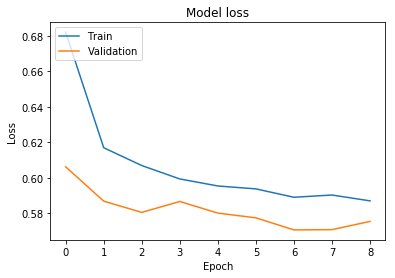

In [62]:
#lr=0.001
visualize_history(history)

#### changing learning rate

In [63]:
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.25))

model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 29s - loss: 0.9980 - acc: 0.5762 - val_loss: 0.6866 - val_acc: 0.7053
Epoch 2/100
 - 27s - loss: 0.7797 - acc: 0.6669 - val_loss: 0.6460 - val_acc: 0.7220
Epoch 3/100
 - 27s - loss: 0.7220 - acc: 0.6895 - val_loss: 0.6295 - val_acc: 0.7277
Epoch 4/100
 - 27s - loss: 0.6877 - acc: 0.7020 - val_loss: 0.6180 - val_acc: 0.7338
Epoch 5/100
 - 27s - loss: 0.6618 - acc: 0.7125 - val_loss: 0.6085 - val_acc: 0.7352
Epoch 6/100
 - 28s - loss: 0.6451 - acc: 0.7191 - val_loss: 0.6045 - val_acc: 0.7381
Epoch 7/100
 - 27s - loss: 0.6308 - acc: 0.7267 - val_loss: 0.5973 - val_acc: 0.7407
Epoch 8/100
 - 28s - loss: 0.6235 - acc: 0.7297 - val_loss: 0.5939 - val_acc: 0.7426
Epoch 9/100
 - 27s - loss: 0.6133 - acc: 0.7347 - val_loss: 0.5902 - val_acc: 0.7435
Epoch 10/100
 - 28s - loss: 0.6071 - acc: 0.7361 - val_loss: 0.5890 - val_acc: 0.7443
Epoch 11/100
 - 30s - loss: 0.6017 - acc: 0.7394 - val_loss: 0.5855 - val_acc: 0.7452
Epoch 12/100


In [64]:
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
accuracy_score(y_test[X_test].values, ypred_nn)

0.7478417386087131

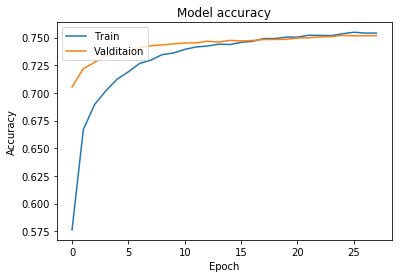

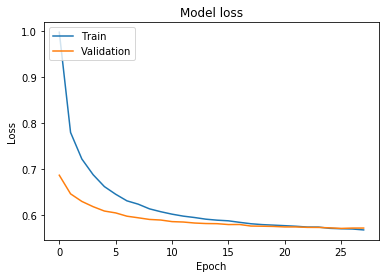

In [65]:
#Adamax
visualize_history(history)

#### Changing optimizer to Adamax is not giving a result

In [66]:
#batch size 16, adding conv1d 64 and 128. Changing kernel 5-3-2
batch_size = 16
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=5, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='elu', padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 57s - loss: 0.8665 - acc: 0.6314 - val_loss: 0.6888 - val_acc: 0.7182
Epoch 2/100
 - 55s - loss: 0.7195 - acc: 0.6918 - val_loss: 0.6410 - val_acc: 0.7309
Epoch 3/100
 - 55s - loss: 0.6741 - acc: 0.7076 - val_loss: 0.6289 - val_acc: 0.7349
Epoch 4/100
 - 55s - loss: 0.6444 - acc: 0.7196 - val_loss: 0.6180 - val_acc: 0.7362
Epoch 5/100
 - 55s - loss: 0.6282 - acc: 0.7270 - val_loss: 0.6066 - val_acc: 0.7405
Epoch 6/100
 - 55s - loss: 0.6151 - acc: 0.7323 - val_loss: 0.5998 - val_acc: 0.7420
Epoch 7/100
 - 57s - loss: 0.6073 - acc: 0.7369 - val_loss: 0.5899 - val_acc: 0.7457
Epoch 8/100
 - 56s - loss: 0.6009 - acc: 0.7390 - val_loss: 0.5885 - val_acc: 0.7456
Epoch 9/100
 - 56s - loss: 0.5922 - acc: 0.7427 - val_loss: 0.5856 - val_acc: 0.7461
Epoch 10/100
 - 55s - loss: 0.5878 - acc: 0.7461 - val_loss: 0.5797 - val_acc: 0.7487
Epoch 11/100
 - 55s - loss: 0.5840 - acc: 0.7465 - val_loss: 0.5804 - val_acc: 0.7478
Epoch 12/100


0.749641678610713


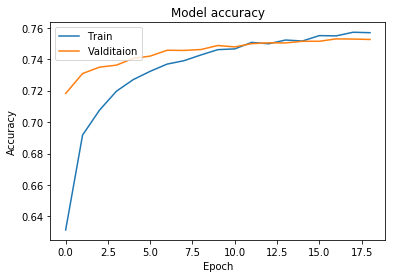

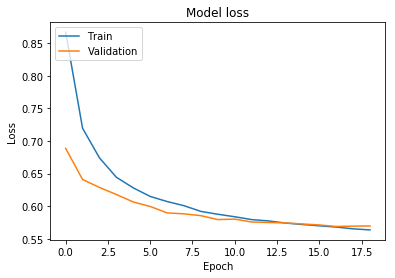

In [67]:
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test[X_test].values, ypred_nn))
visualize_history(history)

In [68]:
#trying NADAM
#initial model
# inspired by https://arxiv.org/pdf/1710.05978.pdf
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=0.0001),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 51s - loss: 0.8724 - acc: 0.6322 - val_loss: 0.6449 - val_acc: 0.7232
Epoch 2/100
 - 30s - loss: 0.6859 - acc: 0.7016 - val_loss: 0.6118 - val_acc: 0.7343
Epoch 3/100
 - 30s - loss: 0.6348 - acc: 0.7247 - val_loss: 0.5984 - val_acc: 0.7407
Epoch 4/100
 - 30s - loss: 0.6104 - acc: 0.7346 - val_loss: 0.5898 - val_acc: 0.7429
Epoch 5/100
 - 30s - loss: 0.5973 - acc: 0.7408 - val_loss: 0.5855 - val_acc: 0.7460
Epoch 6/100
 - 30s - loss: 0.5898 - acc: 0.7455 - val_loss: 0.5852 - val_acc: 0.7459
Epoch 7/100
 - 30s - loss: 0.5834 - acc: 0.7465 - val_loss: 0.5810 - val_acc: 0.7488
Epoch 8/100
 - 30s - loss: 0.5791 - acc: 0.7509 - val_loss: 0.5791 - val_acc: 0.7485
Epoch 9/100
 - 31s - loss: 0.5751 - acc: 0.7523 - val_loss: 0.5744 - val_acc: 0.7494
Epoch 10/100
 - 32s - loss: 0.5709 - acc: 0.7526 - val_loss: 0.5740 - val_acc: 0.7519
Epoch 11/100
 - 30s - loss: 0.5679 - acc: 0.7547 - val_loss: 0.5732 - val_acc: 0.7510
Epoch 12/100


0.7522082597246759


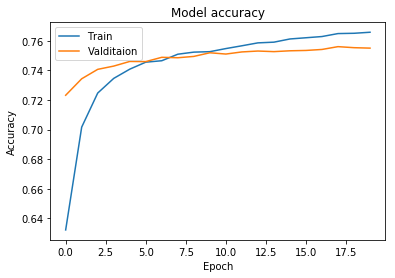

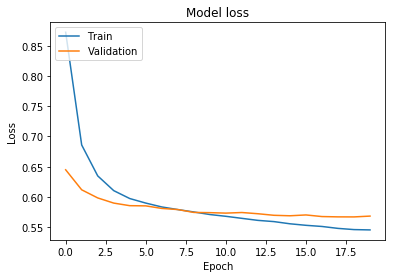

In [69]:
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test[X_test].values, ypred_nn))
visualize_history(history)

Nadam optimizer was not giving any improvement in performance

Coming back to initial structure -  inspired by https://arxiv.org/pdf/1710.05978.pdf
checking RMSprop as mentioned in the paper 

In [70]:
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 29s - loss: 0.8540 - acc: 0.6406 - val_loss: 0.6421 - val_acc: 0.7274
Epoch 2/100
 - 27s - loss: 0.6764 - acc: 0.7078 - val_loss: 0.6121 - val_acc: 0.7357
Epoch 3/100
 - 27s - loss: 0.6268 - acc: 0.7278 - val_loss: 0.5988 - val_acc: 0.7413
Epoch 4/100
 - 28s - loss: 0.6051 - acc: 0.7379 - val_loss: 0.5902 - val_acc: 0.7447
Epoch 5/100
 - 28s - loss: 0.5955 - acc: 0.7430 - val_loss: 0.5858 - val_acc: 0.7470
Epoch 6/100
 - 28s - loss: 0.5899 - acc: 0.7455 - val_loss: 0.5833 - val_acc: 0.7478
Epoch 7/100
 - 28s - loss: 0.5874 - acc: 0.7478 - val_loss: 0.5809 - val_acc: 0.7482
Epoch 8/100
 - 27s - loss: 0.5818 - acc: 0.7487 - val_loss: 0.5783 - val_acc: 0.7481
Epoch 9/100
 - 27s - loss: 0.5790 - acc: 0.7505 - val_loss: 0.5782 - val_acc: 0.7482
Epoch 10/100
 - 27s - loss: 0.5777 - acc: 0.7517 - val_loss: 0.5738 - val_acc: 0.7506
Epoch 11/100
 - 27s - loss: 0.5763 - acc: 0.7524 - val_loss: 0.5729 - val_acc: 0.7515
Epoch 12/100


0.7515082830572314


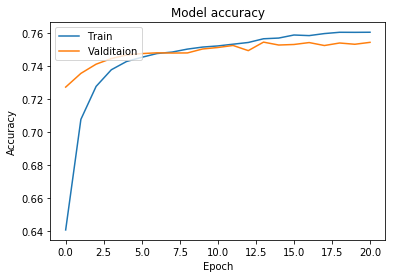

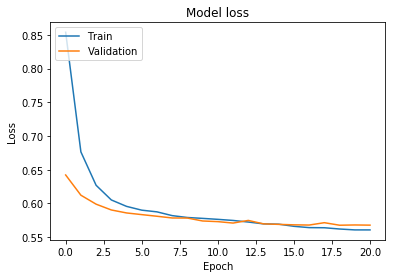

In [71]:
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test[X_test].values, ypred_nn))
visualize_history(history)

RMSprop is giving more or less same results as Adam.

#### Trying fasttext

In [72]:
from gensim.models import FastText

In [73]:
fasttext = FastText(sentences=X_processed,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=multiprocessing.cpu_count())

In [77]:
fasttext.save('fasttext.model')

In [78]:
Xtrain, ytrain = building_subset(X_train, Xtrain, X_processed, fasttext, ytrain, y_train)
Xtest, ytest = building_subset(X_test, Xtest, X_processed, fasttext, ytest, y_test)
Xval, yval = building_subset(X_val, Xval, X_processed, fasttext, yval, y_val)

In [79]:
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_length, vector_size)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 31s - loss: 0.9352 - acc: 0.6093 - val_loss: 0.6714 - val_acc: 0.7176
Epoch 2/100
 - 28s - loss: 0.7061 - acc: 0.6932 - val_loss: 0.6325 - val_acc: 0.7294
Epoch 3/100
 - 27s - loss: 0.6451 - acc: 0.7188 - val_loss: 0.6098 - val_acc: 0.7350
Epoch 4/100
 - 27s - loss: 0.6201 - acc: 0.7291 - val_loss: 0.6020 - val_acc: 0.7400
Epoch 5/100
 - 27s - loss: 0.6103 - acc: 0.7355 - val_loss: 0.5965 - val_acc: 0.7415
Epoch 6/100
 - 27s - loss: 0.6040 - acc: 0.7390 - val_loss: 0.5948 - val_acc: 0.7426
Epoch 7/100
 - 27s - loss: 0.5975 - acc: 0.7434 - val_loss: 0.5889 - val_acc: 0.7441
Epoch 8/100
 - 27s - loss: 0.5942 - acc: 0.7442 - val_loss: 0.5872 - val_acc: 0.7438
Epoch 9/100
 - 27s - loss: 0.5901 - acc: 0.7459 - val_loss: 0.5848 - val_acc: 0.7467
Epoch 10/100
 - 27s - loss: 0.5869 - acc: 0.7474 - val_loss: 0.5819 - val_acc: 0.7465
Epoch 11/100
 - 27s - loss: 0.5857 - acc: 0.7492 - val_loss: 0.5798 - val_acc: 0.7487
Epoch 12/100


0.7476084130528983


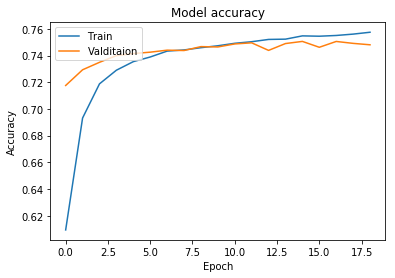

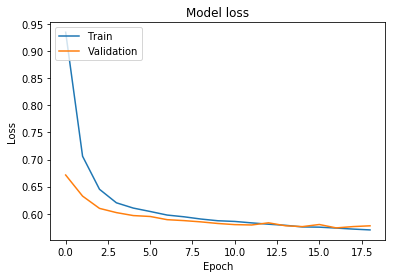

In [80]:
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test[X_test].values, ypred_nn))
visualize_history(history)

#### Using glove

In [6]:
import gensim

C:\Users\miska\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

C:\Users\miska\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
glove_file = datapath('E:\\GitHub\\miskamvedebel\\UdacityNanoDegree\\capstone\\glove.twitter.27B\\glove.twitter.27B.100d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [9]:
model['review']

array([-0.22439  , -0.25909  , -0.29518  , -0.56308  , -0.10016  ,
       -0.32511  ,  0.45673  , -0.54263  ,  0.33272  , -0.075365 ,
        0.045854 , -0.015904 , -2.9818   , -0.33931  ,  0.47892  ,
       -0.39316  ,  0.22864  ,  0.47133  ,  0.15244  ,  0.21797  ,
       -1.0587   , -0.42982  , -0.17551  ,  0.58737  , -0.79153  ,
        0.12705  ,  0.55847  , -0.084414 ,  0.53333  , -0.013097 ,
       -0.025843 , -0.45337  , -0.71405  ,  0.056823 ,  1.0907   ,
        0.43067  ,  0.027348 , -0.02748  , -0.40943  , -0.071372 ,
       -0.22087  , -0.64063  ,  0.11089  ,  0.44241  ,  0.40109  ,
        0.15225  , -0.84026  ,  0.077735 ,  0.10644  , -0.40786  ,
       -0.0492   , -0.04583  , -1.1005   ,  0.24455  , -0.37416  ,
       -0.66829  ,  0.61404  , -0.38694  , -0.085025 , -0.6284   ,
        0.23041  , -0.25372  ,  0.3407   ,  0.16684  ,  0.22396  ,
       -0.025463 ,  0.38793  , -0.86671  ,  0.8284   , -0.24308  ,
        0.29263  , -0.079297 ,  0.18095  ,  0.10471  , -0.0424

Recreating vectors for NN training

In [105]:
np.save('x_train', X_train), np.save('x_test', X_test), np.save('x_val', X_val)

(None, None, None)

In [107]:
y_train.to_csv('y_train.csv', sep=';', index=False)
y_test.to_csv('y_test.csv', sep=';', index=False)
y_val.to_csv('y_val.csv', sep=';', index=False)

In [2]:
with open("tokens_v2.txt", "rb") as fp:   # Unpickling
     X_processed = pickle.load(fp)

In [3]:
y_train = pd.read_csv('y_train.csv', sep=';', header=None)
y_test = pd.read_csv('y_test.csv', sep=';', header=None)
y_val =pd.read_csv('y_val.csv', sep=';', header=None)
X_train = np.load('x_train.npy')
X_test = np.load('x_test.npy') 
X_val = np.load('x_val.npy')

In [29]:
X_train.shape

(90001,)

In [34]:
import cupy as cp
import numpy as np

Xtrain = np.zeros(shape=(X_train.shape[0], 81, 100))
Xval = np.zeros(shape=(X_val.shape[0], 81, 100))
Xtest = np.zeros(shape=(X_test.shape[0], 81, 100))
ytrain = np.zeros(shape=(len(y_train), 3))
yval = np.zeros(shape=(len(y_val), 3))
ytest = np.zeros(shape=(len(y_test), 3))

In [33]:
len(ytrain)

90000

In [5]:
def building_subset_after_load(X_train, Xtrain, X_processed, word2vec, ytrain, y_train):
    for train_ind, index_ in enumerate(X_train):
        tokens = X_processed[index_]
        for token_id, token in enumerate(tokens):
            if token not in word2vec.wv:
                pass
            else:
                Xtrain[train_ind, token_id, :] = word2vec.wv[str(token)]
        if y_train.loc[train_ind, :].values == 0.0:
            ytrain[train_ind, :] = [1., 0., 0.]
        elif y_train.loc[train_ind, :].values == 1.0:
            ytrain[train_ind, :] = [0., 1., 0.]
        else:
            ytrain[train_ind, :] = [0., 0., 1.]
    return Xtrain, ytrain

In [36]:
Xtrain, ytrain = building_subset_after_load(X_train, Xtrain, X_processed, model, ytrain, y_train)
Xtest, ytest = building_subset_after_load(X_test, Xtest, X_processed, model, ytest, y_test)
Xval, yval = building_subset_after_load(X_val, Xval, X_processed, model, yval, y_val)

C:\Users\miska\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\miska\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping

C:\Users\miska\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [40]:
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(81, 100)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 35s - loss: 0.8826 - acc: 0.5855 - val_loss: 0.7409 - val_acc: 0.6692
Epoch 2/100
 - 24s - loss: 0.7647 - acc: 0.6583 - val_loss: 0.7149 - val_acc: 0.6831
Epoch 3/100
 - 24s - loss: 0.7358 - acc: 0.6719 - val_loss: 0.7031 - val_acc: 0.6881
Epoch 4/100
 - 24s - loss: 0.7211 - acc: 0.6779 - val_loss: 0.6984 - val_acc: 0.6893
Epoch 5/100
 - 24s - loss: 0.7089 - acc: 0.6847 - val_loss: 0.6918 - val_acc: 0.6918
Epoch 6/100
 - 24s - loss: 0.6982 - acc: 0.6899 - val_loss: 0.6801 - val_acc: 0.6974
Epoch 7/100
 - 24s - loss: 0.6911 - acc: 0.6942 - val_loss: 0.6765 - val_acc: 0.6981
Epoch 8/100
 - 24s - loss: 0.6841 - acc: 0.6967 - val_loss: 0.6691 - val_acc: 0.7009
Epoch 9/100
 - 24s - loss: 0.6784 - acc: 0.7000 - val_loss: 0.6705 - val_acc: 0.7007
Epoch 10/100
 - 24s - loss: 0.6727 - acc: 0.7025 - val_loss: 0.6576 - val_acc: 0.7064
Epoch 11/100
 - 24s - loss: 0.6683 - acc: 0.7063 - val_loss: 0.6547 - val_acc: 0.7084
Epoch 12/100


0.7198426719109363


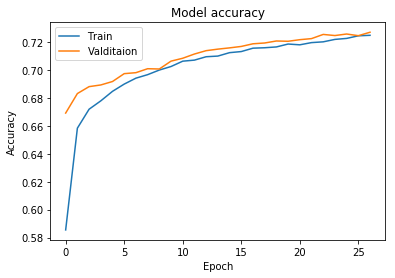

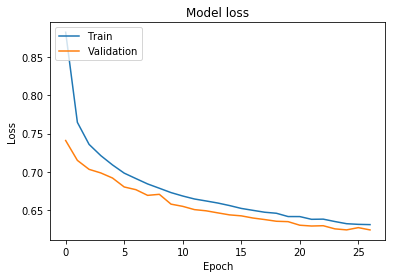

In [43]:
from sklearn.metrics import accuracy_score
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test.values, ypred_nn))
visualize_history(history)

In [7]:
glove_file = datapath('E:\\GitHub\\miskamvedebel\\UdacityNanoDegree\\capstone\\glove.twitter.27B\\glove.twitter.27B.200d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

glove2word2vec(glove_file, tmp_file)
glove200 = KeyedVectors.load_word2vec_format(tmp_file)

In [11]:
Xtrain, ytrain = building_subset_after_load(X_train, Xtrain, X_processed, glove200, ytrain, y_train)
Xtest, ytest = building_subset_after_load(X_test, Xtest, X_processed, glove200, ytest, y_test)
Xval, yval = building_subset_after_load(X_val, Xval, X_processed, glove200, yval, y_val)

C:\Users\miska\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\miska\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [14]:
batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(81, 200)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 84s - loss: 0.8241 - acc: 0.6188 - val_loss: 0.6969 - val_acc: 0.6910
Epoch 2/100
 - 97s - loss: 0.7203 - acc: 0.6821 - val_loss: 0.6873 - val_acc: 0.6979
Epoch 3/100
 - 90s - loss: 0.6966 - acc: 0.6930 - val_loss: 0.6711 - val_acc: 0.7031
Epoch 4/100
 - 50s - loss: 0.6811 - acc: 0.6999 - val_loss: 0.6608 - val_acc: 0.7075
Epoch 5/100
 - 75s - loss: 0.6702 - acc: 0.7060 - val_loss: 0.6561 - val_acc: 0.7106
Epoch 6/100
 - 66s - loss: 0.6607 - acc: 0.7111 - val_loss: 0.6607 - val_acc: 0.7076
Epoch 7/100
 - 87s - loss: 0.6549 - acc: 0.7127 - val_loss: 0.6444 - val_acc: 0.7149
Epoch 8/100
 - 74s - loss: 0.6484 - acc: 0.7145 - val_loss: 0.6438 - val_acc: 0.7164
Epoch 9/100
 - 75s - loss: 0.6438 - acc: 0.7173 - val_loss: 0.6362 - val_acc: 0.7197
Epoch 10/100
 - 70s - loss: 0.6382 - acc: 0.7213 - val_loss: 0.6340 - val_acc: 0.7210
Epoch 11/100
 - 85s - loss: 0.6348 - acc: 0.7228 - val_loss: 0.6299 - val_acc: 0.7217
Epoch 12/100


0.7262424585847138


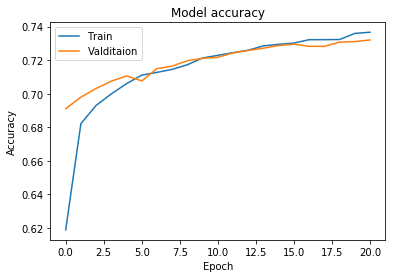

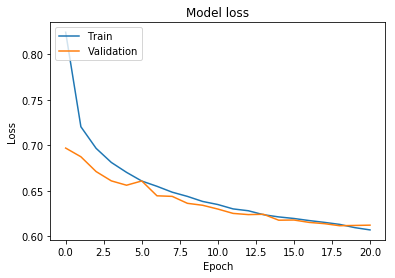

In [16]:
from sklearn.metrics import accuracy_score
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test.values, ypred_nn))
visualize_history(history)

#### Creating own dictionary with 200 dimensions

In [2]:
with open("tokens_v2.txt", "rb") as fp:   # Unpickling
     X_processed = pickle.load(fp)

In [3]:
Xtrain = np.zeros(shape=(90001, 81, 200))
Xval = np.zeros(shape=(30001, 81, 200))
Xtest = np.zeros(shape=(30001, 81, 200))
ytrain = np.zeros(shape=(90001, 3))
yval = np.zeros(shape=(30001, 3))
ytest = np.zeros(shape=(30001, 3))

In [4]:
y_train = pd.read_csv('y_train.csv', sep=';', header=None)
y_test = pd.read_csv('y_test.csv', sep=';', header=None)
y_val =pd.read_csv('y_val.csv', sep=';', header=None)
X_train = np.load('x_train.npy')
X_test = np.load('x_test.npy') 
X_val = np.load('x_val.npy')

In [6]:
from gensim.models.word2vec import Word2Vec
import multiprocessing
model_200 = Word2Vec(sentences=X_processed,
                    size=200, 
                    window=10, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=multiprocessing.cpu_count())

C:\Users\miska\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
model_200.save('model_200.model')

In [8]:
Xtrain, ytrain = building_subset_after_load(X_train, Xtrain, X_processed, model_200, ytrain, y_train)
Xtest, ytest = building_subset_after_load(X_test, Xtest, X_processed, model_200, ytest, y_test)
Xval, yval = building_subset_after_load(X_val, Xval, X_processed, model_200, yval, y_val)

In [10]:
# inspired by https://arxiv.org/pdf/1710.05978.pdf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping

batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(81, 200)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 88s - loss: 0.8387 - acc: 0.6431 - val_loss: 0.6321 - val_acc: 0.7288
Epoch 2/100
 - 98s - loss: 0.6672 - acc: 0.7116 - val_loss: 0.6043 - val_acc: 0.7396
Epoch 3/100
 - 102s - loss: 0.6215 - acc: 0.7278 - val_loss: 0.5902 - val_acc: 0.7451
Epoch 4/100
 - 49s - loss: 0.5985 - acc: 0.7385 - val_loss: 0.5833 - val_acc: 0.7471
Epoch 5/100
 - 63s - loss: 0.5859 - acc: 0.7461 - val_loss: 0.5756 - val_acc: 0.7507
Epoch 6/100
 - 68s - loss: 0.5786 - acc: 0.7498 - val_loss: 0.5743 - val_acc: 0.7520
Epoch 7/100
 - 86s - loss: 0.5728 - acc: 0.7518 - val_loss: 0.5732 - val_acc: 0.7541
Epoch 8/100
 - 79s - loss: 0.5678 - acc: 0.7555 - val_loss: 0.5732 - val_acc: 0.7525
Epoch 9/100
 - 87s - loss: 0.5628 - acc: 0.7580 - val_loss: 0.5714 - val_acc: 0.7538
Epoch 10/100
 - 91s - loss: 0.5590 - acc: 0.7592 - val_loss: 0.5688 - val_acc: 0.7544
Epoch 11/100
 - 79s - loss: 0.5555 - acc: 0.7619 - val_loss: 0.5687 - val_acc: 0.7542
Epoch 12/100

0.7536748775040832


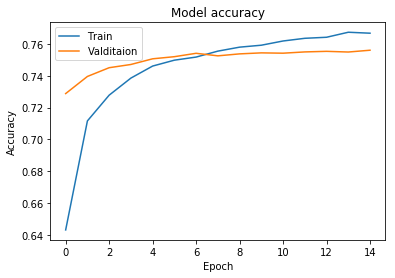

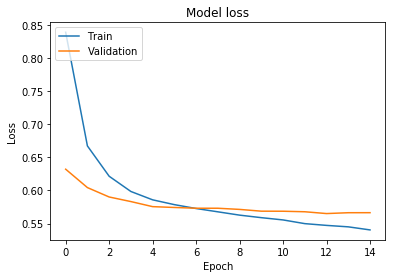

In [12]:
from sklearn.metrics import accuracy_score
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test.values, ypred_nn))
visualize_history(history)

In [14]:
from keras.layers import BatchNormalization
batch_size = 32
nb_epochs = 200

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(81, 200)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(lr=0.00005, decay=1e-6),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/200
 - 70s - loss: 1.1063 - acc: 0.5143 - val_loss: 0.7184 - val_acc: 0.6837
Epoch 2/200
 - 91s - loss: 0.8264 - acc: 0.6485 - val_loss: 0.6667 - val_acc: 0.7150
Epoch 3/200
 - 99s - loss: 0.7643 - acc: 0.6733 - val_loss: 0.6468 - val_acc: 0.7243
Epoch 4/200
 - 60s - loss: 0.7305 - acc: 0.6883 - val_loss: 0.6356 - val_acc: 0.7295
Epoch 5/200
 - 92s - loss: 0.7043 - acc: 0.6976 - val_loss: 0.6254 - val_acc: 0.7326
Epoch 6/200
 - 102s - loss: 0.6886 - acc: 0.7036 - val_loss: 0.6204 - val_acc: 0.7350
Epoch 7/200
 - 98s - loss: 0.6741 - acc: 0.7083 - val_loss: 0.6148 - val_acc: 0.7371
Epoch 8/200
 - 85s - loss: 0.6600 - acc: 0.7162 - val_loss: 0.6086 - val_acc: 0.7404
Epoch 9/200
 - 96s - loss: 0.6520 - acc: 0.7178 - val_loss: 0.6060 - val_acc: 0.7410
Epoch 10/200
 - 95s - loss: 0.6419 - acc: 0.7219 - val_loss: 0.6022 - val_acc: 0.7413
Epoch 11/200
 - 77s - loss: 0.6335 - acc: 0.7258 - val_loss: 0.6003 - val_acc: 0.7424
Epoch 12/200

#### 250 dimension vector

In [3]:
with open("tokens_v2.txt", "rb") as fp:   # Unpickling
     X_processed = pickle.load(fp)

In [2]:
import numpy as np
Xtrain = np.zeros(shape=(90001, 81, 250))
Xval = np.zeros(shape=(30001, 81, 250))
Xtest = np.zeros(shape=(30001, 81, 250))
ytrain = np.zeros(shape=(90001, 3))
yval = np.zeros(shape=(30001, 3))
ytest = np.zeros(shape=(30001, 3))

In [6]:
y_train = pd.read_csv('y_train.csv', sep=';', header=None)
y_test = pd.read_csv('y_test.csv', sep=';', header=None)
y_val =pd.read_csv('y_val.csv', sep=';', header=None)
X_train = np.load('x_train.npy')
X_test = np.load('x_test.npy') 
X_val = np.load('x_val.npy')

In [4]:
from gensim.models.word2vec import Word2Vec
import multiprocessing
model_250 = Word2Vec(sentences=X_processed,
                    size=250, 
                    window=10, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=multiprocessing.cpu_count())
model_250.save('model_250.model')

C:\Users\miska\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
from gensim.models.word2vec import Word2Vec
model_300 = Word2Vec.load('model_250.model')

C:\Users\miska\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
Xtrain, ytrain = building_subset_after_load(X_train, Xtrain, X_processed, model_250, ytrain, y_train)
Xtest, ytest = building_subset_after_load(X_test, Xtest, X_processed, model_250, ytest, y_test)
Xval, yval = building_subset_after_load(X_val, Xval, X_processed, model_250, yval, y_val)

In [9]:
# inspired by https://arxiv.org/pdf/1710.05978.pdf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping

batch_size = 32
nb_epochs = 100

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(81, 250)))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])
history = model.fit(Xtrain, ytrain,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(Xval, yval),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)], 
          verbose=2)

Train on 90001 samples, validate on 30001 samples
Epoch 1/100
 - 118s - loss: 0.8148 - acc: 0.6521 - val_loss: 0.6230 - val_acc: 0.7343
Epoch 2/100
 - 164s - loss: 0.6616 - acc: 0.7149 - val_loss: 0.6021 - val_acc: 0.7393
Epoch 3/100
 - 146s - loss: 0.6182 - acc: 0.7323 - val_loss: 0.5869 - val_acc: 0.7451
Epoch 4/100
 - 119s - loss: 0.5967 - acc: 0.7428 - val_loss: 0.5847 - val_acc: 0.7442
Epoch 5/100
 - 117s - loss: 0.5854 - acc: 0.7464 - val_loss: 0.5775 - val_acc: 0.7498
Epoch 6/100
 - 102s - loss: 0.5757 - acc: 0.7513 - val_loss: 0.5767 - val_acc: 0.7517
Epoch 7/100
 - 84s - loss: 0.5706 - acc: 0.7544 - val_loss: 0.5735 - val_acc: 0.7523
Epoch 8/100
 - 104s - loss: 0.5662 - acc: 0.7564 - val_loss: 0.5705 - val_acc: 0.7530
Epoch 9/100
 - 96s - loss: 0.5605 - acc: 0.7596 - val_loss: 0.5762 - val_acc: 0.7516
Epoch 10/100
 - 103s - loss: 0.5561 - acc: 0.7613 - val_loss: 0.5681 - val_acc: 0.7543
Epoch 11/100
 - 108s - loss: 0.5514 - acc: 0.7636 - val_loss: 0.5698 - val_acc: 0.7552
Epoc

0.750408319722676


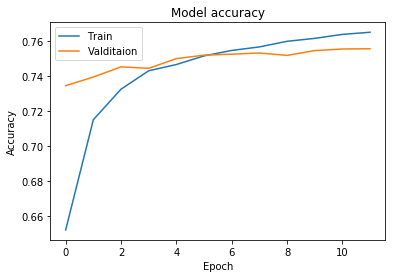

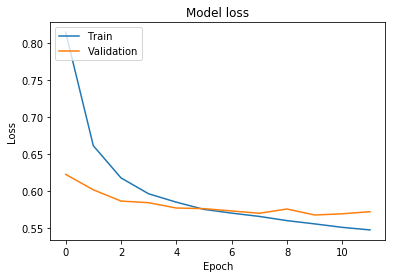

In [15]:
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
ypred_nn = model.predict_classes(Xtest)
ypred_nn = np.array(ypred_nn, dtype=float)
print(accuracy_score(y_test.values, ypred_nn))
visualize_history(history)